# Clan and coda type detection with RNN

> results with and without pretraining, evaluating a simpler architecture

## Clan detection

In [1]:
from sperm_whale_bioacoustics.data import *
from sperm_whale_bioacoustics import model_pretrain

from fastai2.basics import *
from fastai2.learner import *
from fastai2.callback.all import *

Let's load the pretrained model

In [2]:
dls = datasets_clan.dataloaders(bs = 128)
learn = Learner(dls, model_pretrain.Model())
if Path('models/pretrained.pth').exists(): learn.load('pretrained'); # to accomodate the CI pipeline on github

Let's freeze the first layer.

In [3]:
learn.model.lstm1.requires_grad_(False)

LSTM(1, 256, batch_first=True)

We can manipulate the model in place.

In [4]:
learn.model.lstm2.reset_parameters()
learn.model.lin.reset_parameters()

In [5]:
learn.loss_func = BCEWithLogitsLossFlat()

In [6]:
learn.model.cuda()

Model(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 256, batch_first=True)
  (lin): Linear(in_features=256, out_features=1, bias=True)
)

And we should be all set to train!

In [7]:
learn.summary()

Model (Input shape: ['128 x 9'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['128 x 9 x 256', "  265,216    False     
________________________________________________________________
LSTM                 ['128 x 9 x 256', "  526,336    True      
________________________________________________________________
Linear               128 x 1              257        True      
________________________________________________________________

Total params: 791,809
Total trainable params: 526,593
Total non-trainable params: 265,216

Optimizer used: <function Adam at 0x7f07cc43fb90>
Loss function: FlattenedLoss of BCEWithLogitsLoss()

Model unfrozen

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

(0.33113112449646, 0.2089296132326126)

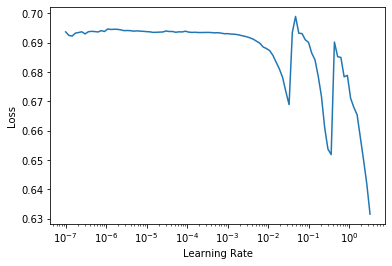

In [8]:
learn.lr_find()

In [9]:
learn.metrics = [accuracy_multi]

In [10]:
learn.fit_one_cycle(20, 5e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.693101,0.691377,0.500000,00:01
1,0.689917,0.676007,0.773684,00:00
2,0.674227,0.588739,0.752632,00:01
3,0.633185,0.479968,0.889474,00:01
4,0.551117,0.279344,0.921053,00:01
5,0.463237,0.256698,0.931579,00:01
6,0.391922,0.237998,0.931579,00:00
7,0.335008,0.223441,0.905263,00:01
8,0.287834,0.200860,0.921053,00:01
9,0.254404,0.202940,0.921053,00:00


The paper reports an accuracy of 95.3% on the clan classification task. Our 93.6% is probably an okay result. I don't believe there is much sense in tweaking the training params at this point.

One thing that should be mentioned here, is that I am reporting the results on the validation set. This makes the code slightly simpler and shorter. Also, for the purposes of my inquiry, I think this is okay (my main goal is to gain better understanding of the ICI and to demonstrate the application of modern ML techniques to this data). For a rigorous scientific study, one should probably consider isolating a test set and running the verification on it, only once.

Without a test set, we risk fitting hyperarameters to our validation set. For a practical discussion of the train - val - test split, I would recommend this [very informative post](https://www.fast.ai/2017/11/13/validation-sets/).

### Does pretraining help?

Pretraining is a very useful technique, in many cases transfer learning is the only path to good results. Here, I am genuinely curious if the pretraining help. If it should help, that would be a very interesting finding.

Let's put this hypothesis to a test.

In [14]:
learn = Learner(
    dls,
    model_pretrain.Model(),
    metrics=[accuracy_multi],
    loss_func=BCEWithLogitsLossFlat()
)

We don't load the weights nor do we modify the architecture

In [15]:
learn.validate()

(#2) [0.6932151317596436,0.5]

Let's train with the same settings as before.

In [16]:
learn.fit_one_cycle(20, 5e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.693099,0.692973,0.500000,00:01
1,0.692972,0.692260,0.757895,00:01
2,0.692486,0.687826,0.736842,00:01
3,0.687545,0.652679,0.652632,00:01
4,0.671638,0.588509,0.710526,00:01
5,0.635740,0.441967,0.868421,00:01
6,0.565996,0.321611,0.921053,00:01
7,0.484575,0.292535,0.878947,00:01
8,0.417169,0.246713,0.915789,00:01
9,0.356033,0.215033,0.926316,00:01


In our experiment, pretraining didn't prove helpful. 

### Would a simpler architecture work?

A two layer RNN strikes me as a very complex model for this task. I am curious if a smaller model could do equally well. Verifying this can help us construct models in the future on similar data. 

In [8]:
class Model(Module):
    def __init__(self):
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=256, batch_first=True)
        self.lin = nn.Linear(256, 1)
    def forward(self, x):
        x = x.unsqueeze(-1).to(torch.float32)
        h = self.lstm1(x)[0]
        h = F.relu(h)
        x = self.lin(h[:, -1, :])
        return x

In [9]:
learn = Learner(
    dls,
    Model(),
    metrics=[accuracy_multi],
    loss_func=BCEWithLogitsLossFlat()
)

In [10]:
learn.fit_one_cycle(20, 5e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.692815,0.692256,0.500000,00:00
1,0.692079,0.689771,0.657895,00:00
2,0.690140,0.679033,0.626316,00:00
3,0.687375,0.669220,0.736842,00:00
4,0.676686,0.618742,0.726316,00:00
5,0.657620,0.569491,0.710526,00:00
6,0.627126,0.533899,0.705263,00:00
7,0.580894,0.355915,0.905263,00:00
8,0.523001,0.314599,0.926316,00:00
9,0.457365,0.248672,0.926316,00:00


A single layer RNN works just as well.

In [42]:
class Model(Module):
    def __init__(self):
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.lin = nn.Linear(64, 1)
    def forward(self, x):
        x = x.unsqueeze(-1).to(torch.float32)
        h = self.lstm1(x)[0]
        h = F.relu(h)
        x = self.lin(h[:, -1, :])
        return x

In [43]:
learn = Learner(
    dls,
    Model(),
    metrics=[accuracy_multi],
    loss_func=BCEWithLogitsLossFlat()
)

In [44]:
learn.fit_one_cycle(20, 5e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.694055,0.693773,0.500000,00:00
1,0.693572,0.692401,0.500000,00:00
2,0.692691,0.689123,0.778947,00:00
3,0.690741,0.678053,0.600000,00:00
4,0.682890,0.680005,0.505263,00:00
5,0.670912,0.617842,0.626316,00:00
6,0.656362,0.585949,0.673684,00:00
7,0.640969,0.561313,0.768421,00:00
8,0.623972,0.539100,0.778947,00:00
9,0.602667,0.507333,0.789474,00:00


Seems that dropping down to 1/4th the hidden state size (256 -> 64) we hit a limitation, where the model no longer performs as well.

## Coda type detection

In [2]:
def get_learner():
    dls = datasets_coda.dataloaders(bs = 128)
    learn = Learner(dls, model_pretrain.Model())
    if Path('models/pretrained.pth').exists(): learn.load('pretrained'); # to accomodate the CI pipeline on github

    learn.model.lstm1.requires_grad_(False)
    learn.model.lstm2.reset_parameters()
    learn.model.lin = nn.Linear(256, dls.c)
    learn.metrics = [accuracy]
    return learn

In [7]:
learn = get_learner()

In [8]:
learn.fit(30, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.485330,2.294498,0.446517,00:01
1,2.335705,2.288693,0.446517,00:01
2,2.304163,2.285231,0.446517,00:02
3,2.292490,2.282421,0.446517,00:02
4,2.277992,2.273564,0.446517,00:02
5,2.269981,2.266062,0.446517,00:01
6,2.265883,2.258453,0.446517,00:01
7,2.253694,2.251024,0.446517,00:01
8,2.249751,2.243055,0.446517,00:02
9,2.239325,2.232406,0.446517,00:02


The model doesn't train very well. Let's see what the culprit might be.

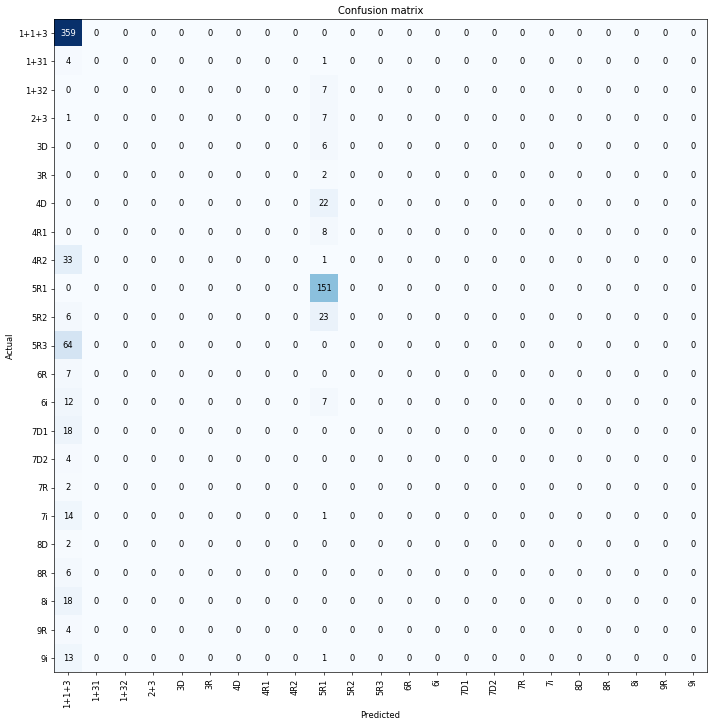

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

The model learns to predict the two most common classes and that is it! It does so perfectly though.

It will be very hard to force the model to learn anything about the less represented classes, the class imbalance is severe.

In [10]:
datasets_coda.items.CodaType.value_counts()

1+1+3    3589
5R1      1510
5R3       642
4R2       340
5R2       287
4D        219
6i        188
8i        178
7D1       177
7i        151
9i        137
4R1        84
2+3        77
1+32       72
6R         67
3D         61
8R         60
1+31       51
9R         43
7D2        35
7R         23
3R         21
8D         20
Name: CodaType, dtype: int64

Our best bet at this point is probably upsampling of poorer represented classes. The paper doesn't go into details how the model was trained and the repository also doesn't contain any relevant information, as fat as I can tell.

It's hard to say how the authors approached this problem, but that is not really all that important. Upsampling is a very useful and powerful technique, let's see how far we can take it.

The `get_idxs` method of `DataLoaders` samples the `idxs` to be used in an epoch of training:

In [11]:
learn.dls.get_idxs()[:10]

[3630, 620, 1213, 4444, 4304, 1115, 3522, 4162, 3333, 3139]

In [12]:
len(learn.dls.get_idxs())

7228

Let's modify it to return a more equal number of idxs corresponding to each of the classes. Let's calculate the weights we will use for sampling.

In [13]:
df = pd.DataFrame(1 / learn.dls.items.CodaType.value_counts())
weights = learn.dls.items.CodaType.apply(lambda x: df.to_dict()['CodaType'][x])

In [14]:
learn.dls.train.items.sample(n=10000, weights=weights, replace=True).CodaType.value_counts()

6i       475
1+1+3    469
9R       469
7D1      468
4R2      463
4D       462
4R1      449
3D       443
1+32     440
6R       438
3R       437
5R3      434
8D       433
9i       428
7D2      428
7R       427
1+31     414
5R2      414
8R       413
5R1      410
7i       402
8i       395
2+3      389
Name: CodaType, dtype: int64

This is looking much better. Let's now pull all of this together.

In [2]:
def sample_epoch(self):
    df = pd.DataFrame(1 / self.items.CodaType.value_counts())
    weights = self.items.CodaType.apply(lambda x: df.to_dict()['CodaType'][x])
    self.n = 100_000 # going for bigger epochs as this will require quite a bit of training
    upsampled_idxs = self.items.sample(n=self.n, weights=weights, replace=True).index
    return [np.where(self.items.index == i)[0][0] for i in upsampled_idxs]

In [30]:
learn = get_learner()
learn.dls.train.get_idxs = types.MethodType(sample_epoch, learn.dls.train)

A quick sanity test

In [25]:
idxs = learn.dls.train.get_idxs()
learn.dls.train.items.iloc[idxs].CodaType.value_counts()

8D       4467
6R       4438
4D       4403
7D1      4387
7R       4372
5R3      4372
5R2      4369
1+1+3    4364
6i       4361
1+31     4358
7D2      4357
3D       4350
7i       4346
4R1      4342
8i       4342
9R       4341
8R       4330
4R2      4322
1+32     4295
3R       4288
5R1      4282
2+3      4261
9i       4253
Name: CodaType, dtype: int64

Let us train

In [26]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.142259,2.204962,0.389303,00:19
1,1.917103,2.034287,0.656716,00:19
2,1.808569,1.923597,0.728856,00:19
3,1.695975,1.832408,0.773632,00:19
4,1.604863,1.735847,0.894279,00:19
5,1.537120,1.651855,0.966418,00:19
6,1.477692,1.588840,0.986318,00:19
7,1.431008,1.532195,0.986318,00:19
8,1.379324,1.461624,0.985075,00:19
9,1.332867,1.400233,0.992537,00:19


In [28]:
learn.fit(5, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.313218,1.360112,0.993781,00:19
1,1.295589,1.340165,0.995025,00:19
2,1.291922,1.331838,0.993781,00:19
3,1.278093,1.316814,0.996269,00:19
4,1.244912,1.287412,0.995025,00:19


In [29]:
learn.fit(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.240243,1.285051,0.995025,00:19
1,1.233052,1.282633,0.995025,00:19
2,1.228914,1.280479,0.996269,00:19
3,1.226334,1.266625,0.996269,00:19
4,1.233800,1.268806,0.995025,00:19


We were not exactly able to get to the accuracy of 99.9% reported in the paper. Still, this seems good enough.

Let's see whether we can get a smiliar result without pretraining and with the entire model unfrozen.

In [3]:
dls = datasets_coda.dataloaders(bs = 128)
learn = Learner(dls, model_pretrain.Model())
learn.model.lin = nn.Linear(256, dls.c)
learn.metrics = [accuracy]
learn.dls.train.get_idxs = types.MethodType(sample_epoch, learn.dls.train)
learn.dls.train.n = 100_000

In [4]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.428250,0.360457,0.962687,00:19
1,0.089676,0.043444,0.993781,00:20
2,0.052602,0.031867,0.987562,00:19
3,0.031480,0.017213,0.997512,00:19
4,0.024979,0.027840,0.993781,00:19
5,0.028536,0.029325,0.991294,00:19
6,0.023300,0.139098,0.936567,00:19
7,0.027956,0.013908,0.995025,00:20
8,0.018284,0.015746,0.995025,00:19
9,0.017679,0.029007,0.993781,00:19


In [5]:
learn.fit(5, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.011762,0.011826,0.995025,00:19
1,0.012083,0.009542,0.995025,00:19
2,0.012008,0.004144,0.997512,00:19
3,0.016163,0.030589,0.991294,00:19
4,0.011651,0.012466,0.996269,00:19


In [6]:
learn.fit(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.005980,0.004953,0.997512,00:19
1,0.006988,0.002272,0.998756,00:19
2,0.006873,0.001890,1.000000,00:19
3,0.006742,0.001953,0.998756,00:19
4,0.006238,0.001294,1.000000,00:19


Seems that pretraining is not necessary and that training the entire model helps.

Let's also check if we could do with a much smaller model.

In [12]:
class Model(Module):
    def __init__(self):
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=32, batch_first=True)
        self.lin = nn.Linear(32, 1)
    def forward(self, x):
        x = x.unsqueeze(-1).to(torch.float32)
        h = self.lstm1(x)[0]
        h = F.relu(h)
        x = self.lin(h[:, -1, :])
        return x

In [13]:
dls = datasets_coda.dataloaders(bs = 128)
learn = Learner(dls, Model())
learn.model.lin = nn.Linear(32, dls.c)
learn.metrics = [accuracy]
learn.dls.train.get_idxs = types.MethodType(sample_epoch, learn.dls.train)
learn.dls.train.n = 100_000

In [14]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.577530,1.470940,0.389303,00:19
1,1.001337,0.967359,0.666667,00:19
2,0.723600,0.694374,0.791045,00:19
3,0.546421,0.521350,0.840796,00:19
4,0.401402,0.455676,0.838308,00:19
5,0.282333,0.381733,0.859453,00:19
6,0.219876,0.376542,0.861940,00:20
7,0.174598,0.310206,0.875622,00:19
8,0.148386,0.249020,0.912935,00:19
9,0.162041,0.284373,0.880597,00:19


In [15]:
learn.fit(5, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.102815,0.221196,0.910448,00:19
1,0.087429,0.166963,0.970149,00:19
2,0.083025,0.163392,0.961443,00:19
3,0.072956,0.121880,0.975124,00:19
4,0.064175,0.104495,0.988806,00:19


In [16]:
learn.fit(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.060739,0.102531,0.986318,00:19
1,0.056660,0.102899,0.986318,00:19
2,0.053389,0.093679,0.988806,00:19
3,0.052025,0.091438,0.990050,00:19
4,0.051068,0.083065,0.991294,00:19


A slightly lower accuracy with the same amount of training.